In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
data = pd.read_csv('/content/predictive_maintenance_data.csv')

data = data.iloc[:500]


# Preprocess the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['vibration', 'temperature', 'pressure', 'acoustic', 'flow_rate']])

# Split the data into training and validation sets
X_train, X_val = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Convert the training and validation data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)
batch_size = 32  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU(True),
            nn.Linear(10, 5),
            nn.ReLU(True),
            nn.Linear(5, 2),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(True),
            nn.Linear(5, 10),
            nn.ReLU(True),
            nn.Linear(10, 5),
            nn.Sigmoid()  # Use Sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for data in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        output = model(data[0])  # Forward pass
        loss = criterion(output, data[0])  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in val_loader:
            output = model(data[0])
            loss = criterion(output, data[0])
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Print loss for every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}')

# After training, you can test the model on unseen data as previously described.

Epoch [1/10], Training Loss: 0.0283, Validation Loss: 0.0303
Epoch [2/10], Training Loss: 0.0281, Validation Loss: 0.0300
Epoch [3/10], Training Loss: 0.0275, Validation Loss: 0.0296
Epoch [4/10], Training Loss: 0.0273, Validation Loss: 0.0293
Epoch [5/10], Training Loss: 0.0270, Validation Loss: 0.0290
Epoch [6/10], Training Loss: 0.0269, Validation Loss: 0.0288
Epoch [7/10], Training Loss: 0.0268, Validation Loss: 0.0285
Epoch [8/10], Training Loss: 0.0266, Validation Loss: 0.0283
Epoch [9/10], Training Loss: 0.0260, Validation Loss: 0.0281
Epoch [10/10], Training Loss: 0.0260, Validation Loss: 0.0279


Columns: ['timestamp', 'machine_id', 'vibration', 'temperature', 'pressure', 'acoustic', 'flow_rate']


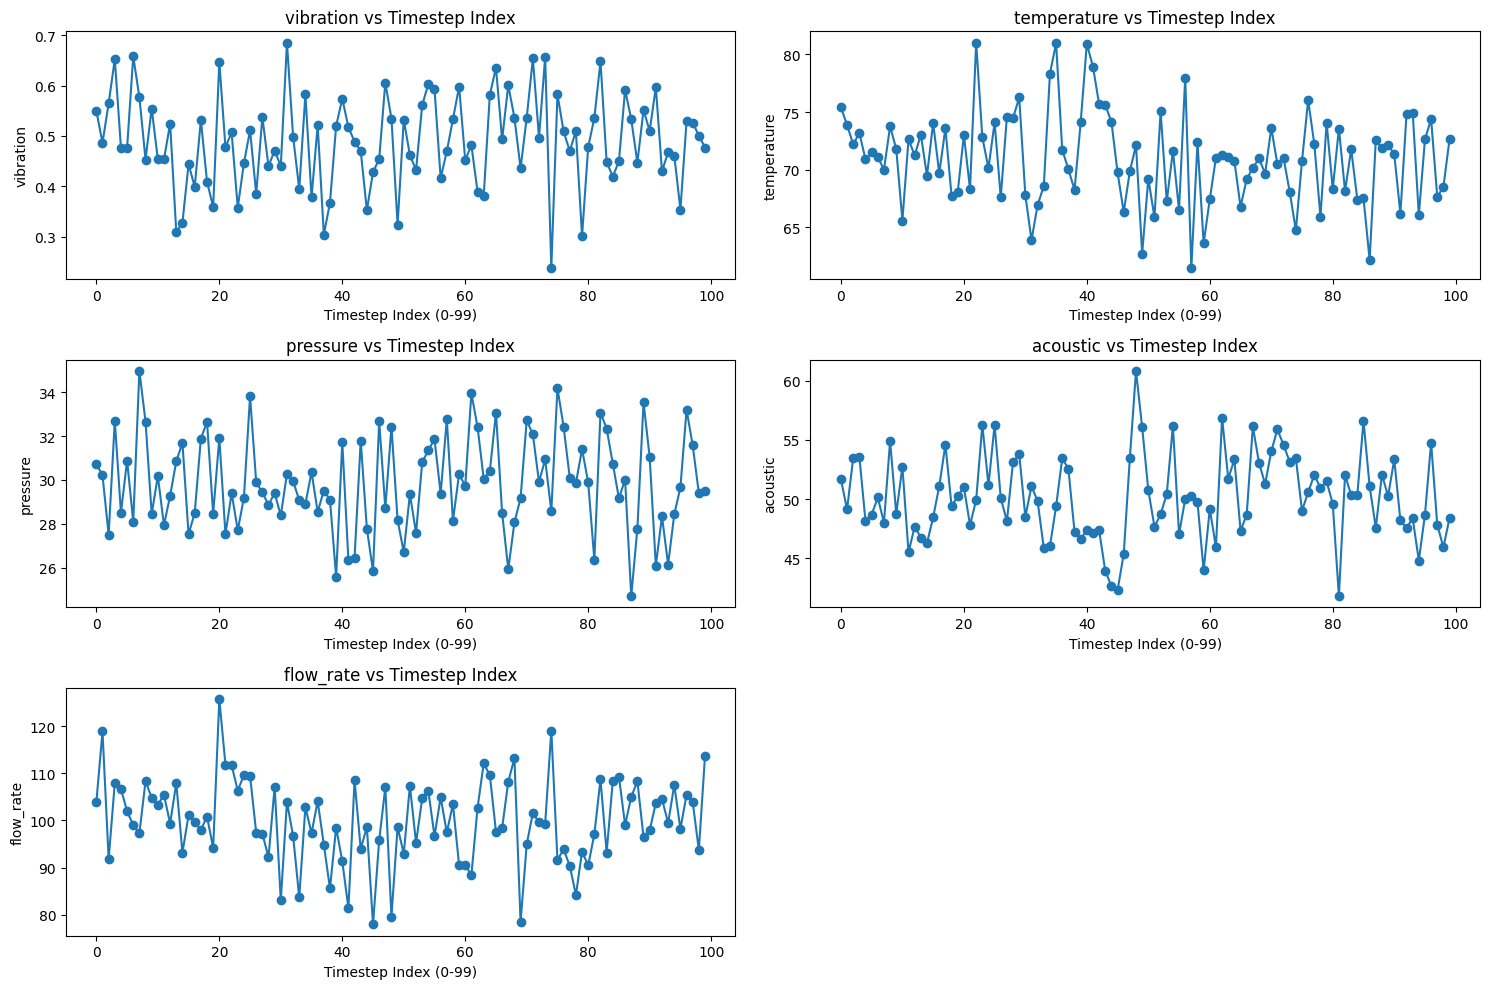

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('predictive_maintenance_data.csv')

# Show column names to verify
print("Columns:", df.columns.tolist())

# Define sensors and select first 100 rows
sensors = ['vibration', 'temperature', 'pressure', 'acoustic', 'flow_rate']
subset = df.iloc[:100]

# Create a range for x-axis (0 to 99)
x = range(100)

# Plotting
plt.figure(figsize=(15, 10))
for i, sensor in enumerate(sensors):
    plt.subplot(3, 2, i + 1)
    plt.plot(x, subset[sensor], marker='o')
    plt.title(f'{sensor} vs Timestep Index')
    plt.xlabel('Timestep Index (0-99)')
    plt.ylabel(sensor)
    plt.tight_layout()

plt.show()


In [ ]:
# After you train your model
import torch

# Assuming 'model' is your trained autoencoder
torch.save(model.state_dict(), 'ae_weights.pth')



Average Reconstruction Error on Validation Set: 0.0240
Number of Anomalies Detected: 4


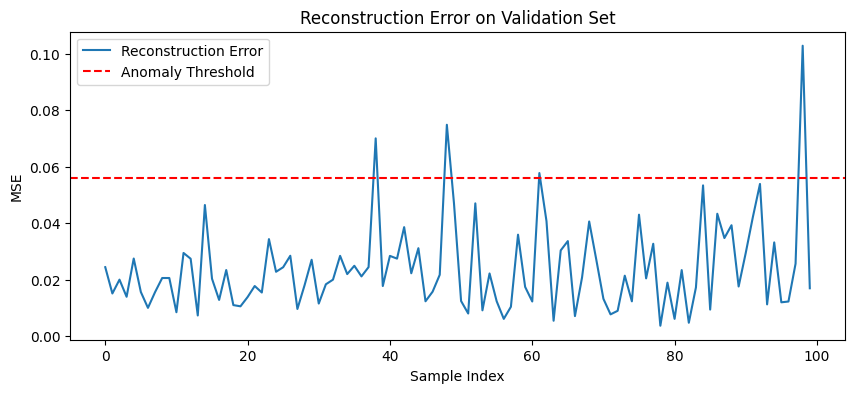

In [ ]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Store original and reconstructed inputs
original_data = []
reconstructed_data = []
reconstruction_errors = []

with torch.no_grad():  # No need to compute gradients
    for data in val_loader:
        inputs = data[0]
        outputs = model(inputs)

        # Store for comparison
        original_data.append(inputs.numpy())
        reconstructed_data.append(outputs.numpy())

        # Compute reconstruction error (MSE per sample)
        error = torch.mean((outputs - inputs) ** 2, dim=1)  # One error per sample
        reconstruction_errors.extend(error.numpy())

# Convert list of arrays to NumPy arrays
original_data = np.vstack(original_data)
reconstructed_data = np.vstack(reconstructed_data)
reconstruction_errors = np.array(reconstruction_errors)

# Print average reconstruction error
print(f"\nAverage Reconstruction Error on Validation Set: {reconstruction_errors.mean():.4f}")

# Optional: Flag samples as anomalies if error > threshold
threshold = reconstruction_errors.mean() + 2 * reconstruction_errors.std()
anomalies = reconstruction_errors > threshold
print(f"Number of Anomalies Detected: {np.sum(anomalies)}")

# Plot reconstruction errors
plt.figure(figsize=(10, 4))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error on Validation Set')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Example: dummy sensor values for a sequence of 30 timesteps
# Each row should have the same number of features as in training (e.g., 5)
# Replace these with actual scaled sensor values
new_sequence = np.array([
    [0.6, 0.7, 0.4, 0.8, 0.5],
    [0.61, 0.72, 0.43, 0.78, 0.52],
    [0.63, 0.74, 0.42, 0.76, 0.51],
    [0.62, 0.75, 0.41, 0.74, 0.53],
    [0.60, 0.73, 0.40, 0.75, 0.55],
    [0.58, 0.71, 0.39, 0.76, 0.54],
    [0.59, 0.70, 0.38, 0.77, 0.56],
    [0.61, 0.72, 0.37, 0.78, 0.57],
    [0.62, 0.73, 0.36, 0.79, 0.58],
    [0.63, 0.74, 0.35, 0.80, 0.59],
    [0.64, 0.75, 0.34, 0.81, 0.60],
    [0.65, 0.76, 0.33, 0.82, 0.61],
    [0.66, 0.77, 0.32, 0.83, 0.62],
    [0.67, 0.78, 0.31, 0.84, 0.63],
    [0.68, 0.79, 0.30, 0.85, 0.64],
    [0.69, 0.80, 0.29, 0.86, 0.65],
    [0.70, 0.81, 0.28, 0.87, 0.66],
    [0.71, 0.82, 0.27, 0.88, 0.67],
    [0.72, 0.83, 0.26, 0.89, 0.68],
    [0.73, 0.84, 0.25, 0.90, 0.69],
    [0.74, 0.85, 0.24, 0.91, 0.70],
    [0.75, 0.86, 0.23, 0.92, 0.71],
    [0.76, 0.87, 0.22, 0.93, 0.72],
    [0.77, 0.88, 0.21, 0.94, 0.73],
    [0.78, 0.89, 0.20, 0.95, 0.74],
    [0.79, 0.90, 0.19, 0.96, 0.75],
    [0.80, 0.91, 0.18, 0.97, 0.76],
    [0.81, 0.92, 0.17, 0.98, 0.77],
    [0.82, 0.93, 0.16, 0.99, 0.78],
    [0.83, 0.94, 0.15, 1.00, 0.79],
])

# Reshape to (1, 30, 5) for prediction
new_sequence = new_sequence.reshape(1, 30, -1)

# Predict using the classification model
prediction = model_fail.predict(new_sequence)

# Interpret the result
predicted_class = 1 if prediction[0][0] >= 0.5 else 0
print(f"Predicted Failure Class: {predicted_class} (Probability: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Failure Class: 0 (Probability: 0.0895)
